In [58]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path
import matplotlib
import matplotlib.cm as cm

from os import getcwd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import NMF
import scipy.cluster.hierarchy as hac 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

In [14]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [15]:
cue_ecog = pd.read_csv('ecog_cue.csv').iloc[:, :4]
cue_ecog = cue_ecog[cue_ecog['dir'] == "+"]
cue_ecog['nat_x'] = 0
cue_ecog['nat_y'] = 0
cue_ecog['nat_z'] = 0
cue_ecog['leadDBS_x'] = 0
cue_ecog['leadDBS_y'] = 0
cue_ecog['leadDBS_z'] = 0
cue_ecog['mni_linear_x'] = 0
cue_ecog['mni_linear_y'] = 0
cue_ecog['mni_linear_z'] = 0
cue_ecog['mni_nonlinear_x'] = 0
cue_ecog['mni_nonlinear_y'] = 0
cue_ecog['mni_nonlinear_z'] = 0
cue_ecog['fs_anatomy'] = 0

In [16]:
cue_ecog.head()
cue_ecog.shape

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,mni_linear_x,mni_linear_y,mni_linear_z,mni_nonlinear_x,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy
0,DBS3003,2,+,Onset,0,0,0,0,0,0,0,0,0,0,0,0,0
1,DBS3003,3,+,Onset,0,0,0,0,0,0,0,0,0,0,0,0,0
2,DBS3003,4,+,Onset,0,0,0,0,0,0,0,0,0,0,0,0,0
3,DBS3003,5,+,Onset,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DBS3003,6,+,Onset,0,0,0,0,0,0,0,0,0,0,0,0,0


(220, 17)

In [34]:
item=0
SUBJECT = cue_ecog.iloc[item, 0]
CHAN = cue_ecog.iloc[item, 1]
PATH = f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/'
elec_orig_info = pd.read_csv(f'{PATH}/{SUBJECT}_electrode.txt', sep='\t').iloc[CHAN]
elec_orig_info

id                                 3
starts                         39700
ends                           52100
duration                       12400
type                            ecog
filetype                 trellis.ns5
channel                        raw 3
electrode                   ecog_103
connector                          1
port                               A
bank                               @
strip                            1.0
comment                          PMT
target                           SMC
side                               L
nat_x                     -63.826808
nat_y                      22.211691
nat_z                       0.631444
leadDBS_x                 -62.950385
leadDBS_y                 -33.256271
leadDBS_z                   6.265088
tkRAS_x                   -68.030605
tkRAS_y                    -8.864359
tkRAS_z                    -1.296474
mni_linear_x              -71.605663
mni_linear_y              -29.702442
mni_linear_z                4.014751
m

In [17]:
for item in range(cue_ecog.shape[0]):
    SUBJECT = cue_ecog.iloc[item, 0]
    CHAN = cue_ecog.iloc[item, 1]
    print(item)
    
    PATH = f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/'
    elec_orig_info = pd.read_csv(f'{PATH}/{SUBJECT}_electrode.txt', sep='\t').iloc[CHAN]
    cue_ecog['nat_x'][item] = elec_orig_info['nat_x']
    cue_ecog['nat_y'][item] = elec_orig_info['nat_y']
    cue_ecog['nat_z'][item] = elec_orig_info['nat_z']
    cue_ecog['leadDBS_x'][item] = elec_orig_info['leadDBS_x']
    cue_ecog['leadDBS_y'][item] = elec_orig_info['leadDBS_y']
    cue_ecog['leadDBS_z'][item] = elec_orig_info['leadDBS_z']
    cue_ecog['mni_linear_x'][item] = elec_orig_info['mni_linear_x']
    cue_ecog['mni_linear_y'][item] = elec_orig_info['mni_linear_y']
    cue_ecog['mni_linear_z'][item] = elec_orig_info['mni_linear_z']
    cue_ecog['mni_nonlinear_x'][item] = elec_orig_info['mni_nonlinear_x']
    cue_ecog['mni_nonlinear_y'][item] = elec_orig_info['mni_nonlinear_y']
    cue_ecog['mni_nonlinear_z'][item] = elec_orig_info['mni_nonlinear_z']
    cue_ecog['fs_anatomy'][item] = elec_orig_info['fs_anatomy']
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


In [5]:
cue_ecog_info = cue_ecog
cue_ecog_info.drop([125, 141, 142, 143, 144, 220, 221, 222, 223, 224], inplace=True)
cue_ecog_info.reset_index(inplace=True, drop=True)
cue_ecog_info

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,mni_linear_x,mni_linear_y,mni_linear_z,mni_nonlinear_x,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy
0,DBS3003,2,+,Onset,-63.826808,22.211691,0.631444,-62.950385,-33.256271,6.265088,-71.605663,-29.702442,4.014751,-73.999646,-29.419723,5.061449,superiortemporal
1,DBS3003,3,+,Onset,-63.510143,23.719010,2.892338,-62.633591,-31.714095,8.502333,-71.273390,-27.313060,5.573327,-73.690371,-26.985611,6.725981,superiortemporal
2,DBS3003,4,+,Onset,-62.761465,25.276904,5.229201,-61.884780,-30.120196,10.814744,-70.481531,-24.838860,7.163111,-72.844792,-24.482477,8.441674,superiortemporal
3,DBS3003,5,+,Onset,-62.838204,26.799445,7.513011,-61.961389,-28.562425,13.074675,-70.567963,-22.429638,8.757465,-73.084052,-22.110149,9.977648,superiortemporal
4,DBS3003,6,+,Onset,-62.123425,28.358452,9.851519,-61.246477,-26.967384,15.388715,-69.812182,-19.954056,10.350092,-72.327858,-19.690011,11.550026,superiortemporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,DBS3030,108,+,Sus,-76.534879,-8.003979,-17.721643,-68.039989,-38.835701,28.640327,-63.814507,-38.342814,23.344240,-69.130202,-38.363786,24.575131,superiortemporal
206,DBS3030,109,+,Sus,-75.413623,-6.872528,-15.355890,-67.124174,-36.431798,29.871878,-62.927443,-36.104600,24.965314,-68.667917,-36.017307,26.309593,supramarginal
207,DBS3031,0,+,Sus,-74.587754,-6.050989,-12.836988,-66.457811,-34.230567,31.425067,-62.275680,-34.063845,26.929558,-68.307124,-33.850116,28.447585,supramarginal
208,DBS3031,2,+,Sus,-75.441807,-4.057924,-16.291589,-67.546692,-34.674956,27.519579,-63.323166,-34.327493,22.473312,-69.241689,-34.069831,23.759149,supramarginal


In [18]:
cue_ecog_info.columns

Index(['subj', 'channel', 'dir', 'type', 'nat_x', 'nat_y', 'nat_z',
       'leadDBS_x', 'leadDBS_y', 'leadDBS_z', 'mni_linear_x', 'mni_linear_y',
       'mni_linear_z', 'mni_nonlinear_x', 'mni_nonlinear_y', 'mni_nonlinear_z',
       'fs_anatomy'],
      dtype='object')

In [25]:
cue_ecog_info.iloc[:, 10:13]

,mni_linear_x,mni_linear_y,mni_linear_z
0,-71.605663,-29.702442,4.014751
1,-71.273390,-27.313060,5.573327
2,-70.481531,-24.838860,7.163111
3,-70.567963,-22.429638,8.757465
4,-69.812182,-19.954056,10.350092
...,...,...,...
205,-63.814507,-38.342814,23.344240
206,-62.927443,-36.104600,24.965314
207,-62.275680,-34.063845,26.929558
208,-63.323166,-34.327493,22.473312


In [8]:
cue_ecog_loc = {"elecmatrix":cue_ecog_info.iloc[:, 13:16]}
savemat("processed_data/cue_ecog_loc.mat", cue_ecog_loc)

In [37]:
cue_ecog_info_stg.shape
cue_ecog_info.shape

(97, 17)

(210, 17)

In [35]:
cue_ecog_info_stg = cue_ecog_info[cue_ecog_info['fs_anatomy'] == 'superiortemporal']


cue_ecog_loc_stg = {"elecmatrix_stg":cue_ecog_info_stg.iloc[:, 13:16]}
savemat("processed_data/cue_ecog_loc_stg.mat", cue_ecog_loc_stg)

In [38]:
cue_ecog_info_onset = cue_ecog_info_stg[cue_ecog_info_stg['type'] == 'Onset']

cue_ecog_loc_onset = {"elecmatrix_onset":cue_ecog_info_onset.iloc[:, 13:16]}
savemat("processed_data/cue_ecog_loc_onset.mat", cue_ecog_loc_onset)

In [39]:
cue_ecog_info_sus = cue_ecog_info_stg[cue_ecog_info_stg['type'] == 'Sus']

cue_ecog_loc_sus = {"elecmatrix_sus":cue_ecog_info_sus.iloc[:, 13:16]}
savemat("processed_data/cue_ecog_loc_sus.mat", cue_ecog_loc_sus)

In [40]:
cue_ecog_info_three = cue_ecog_info_stg[cue_ecog_info_stg['type'] == 'Three']

cue_ecog_loc_three = {"elecmatrix_three":cue_ecog_info_three.iloc[:, 13:16]}
savemat("processed_data/cue_ecog_loc_three.mat", cue_ecog_loc_three)

In [42]:
cue_ecog.to_csv('cue_ecog_info.csv')

In [7]:
def zscore_bseline(input_mat):
    use_unit_z = np.zeros(input_mat.shape)
    for item in range(input_mat.shape[0]):
        use_unit = input_mat[item]
        unit_baseline = use_unit[0:1500]
        unit_baseline_mean = np.mean(unit_baseline)
        unit_baseline_std = np.std(unit_baseline)
        use_unit_z[item] = (use_unit - unit_baseline_mean)/unit_baseline_std
    return use_unit_z

In [9]:
all_hg_ave_activity = loadmat("processed_data/all_cue_ecog.mat")
ecog_hg_onset_mean = all_hg_ave_activity['ecog_hg_onset_mean']
ecog_hg_onset_sem = all_hg_ave_activity['ecog_hg_onset_sem']
ecog_hg_sus_mean = all_hg_ave_activity['ecog_hg_sus_mean']
ecog_hg_sus_sem = all_hg_ave_activity['ecog_hg_sus_sem']
ecog_hg_three_mean = all_hg_ave_activity['ecog_hg_three_mean']
ecog_hg_three_sem = all_hg_ave_activity['ecog_hg_three_sem']

ecog_hg_mean = np.concatenate((ecog_hg_onset_mean, ecog_hg_sus_mean, ecog_hg_three_mean))
ecog_hg_mean.shape

(220, 5000)

In [11]:
use_cmap = sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

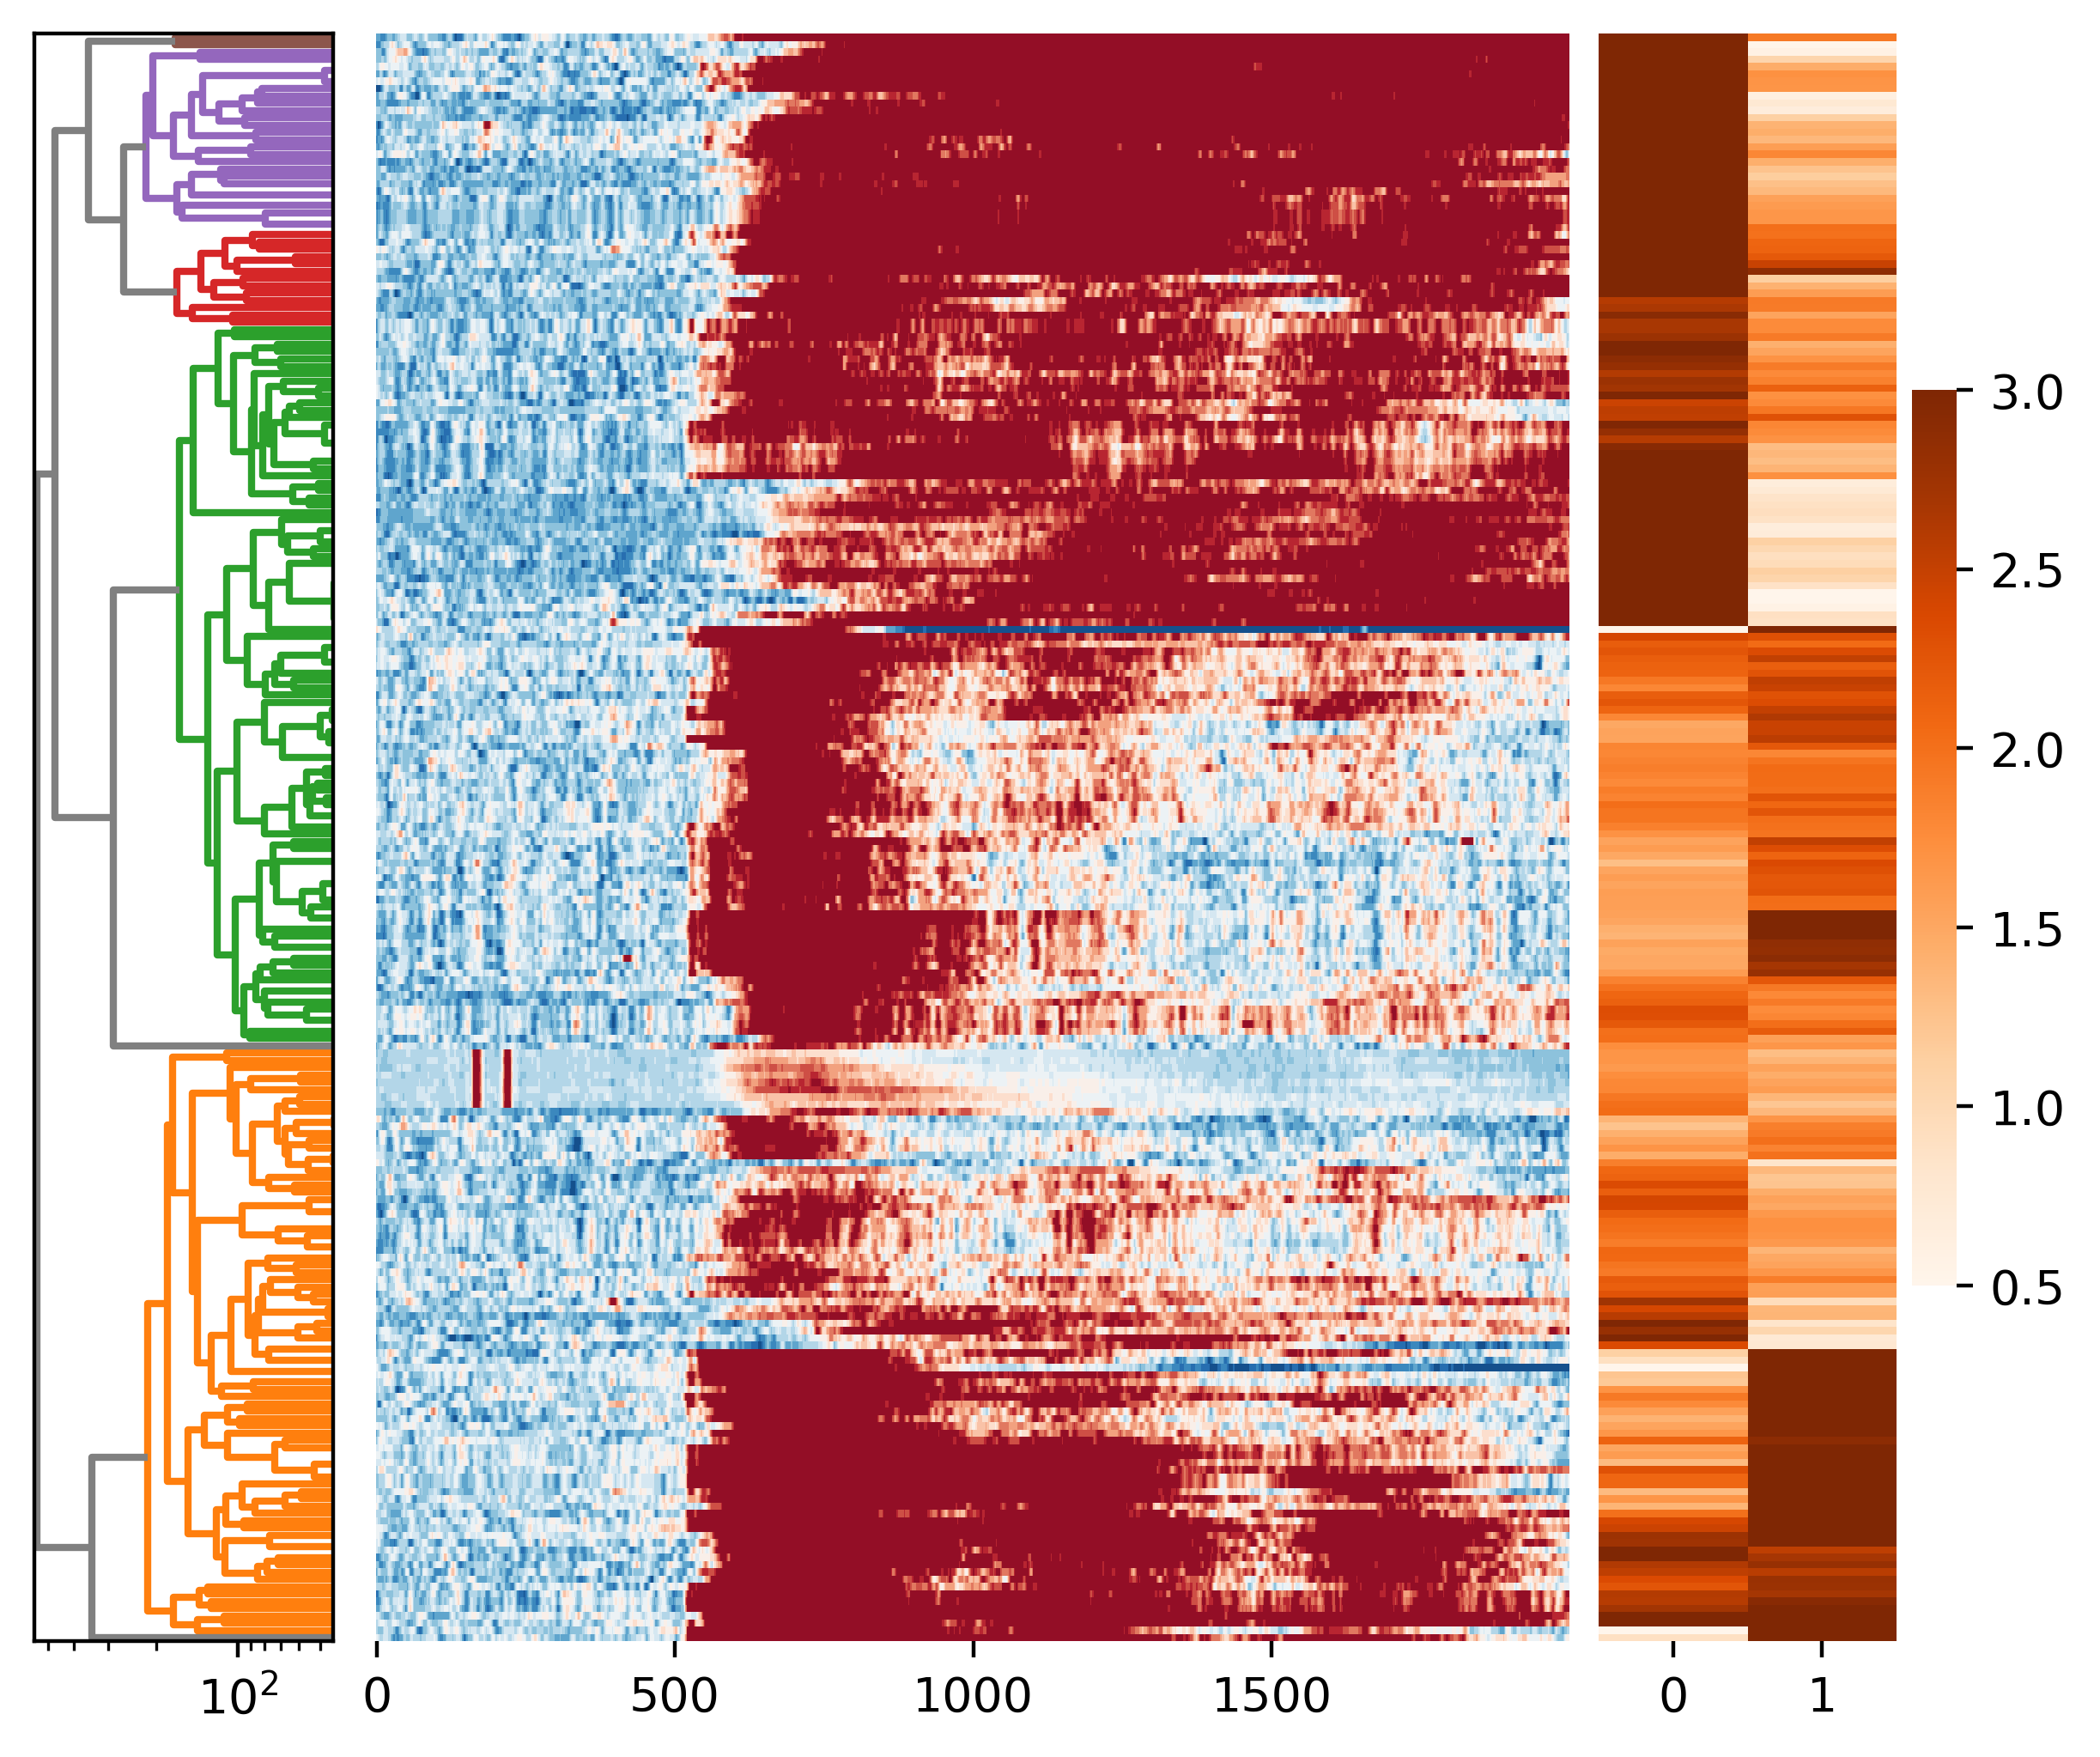

In [12]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 4, 1]})


Z = hac.linkage(zscore_bseline(ecog_hg_mean)[:, 1500:3000], 
                metric='euclidean', optimal_ordering=1, method='weighted')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, 
                    color_threshold=250, above_threshold_color="grey")
axs[0].set_xlim(560, 45)
axs[0].set_xscale('log')

cos_ordered_units = np.zeros(ecog_hg_mean.shape)
for item in range(ecog_hg_mean.shape[0]):
    cos_ordered_units[item] = ecog_hg_mean[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[1], 
            yticklabels=False, xticklabels=500)

NMF_input = zscore_bseline(ecog_hg_mean)[:, 1000:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=2, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.01)
NMF_output = model.fit_transform(NMF_input)

NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[2], 
            vmax=3, vmin=0.5, cmap='Oranges', 
            yticklabels=False) #
#plt.colorbar(shw)

plt.show();

In [18]:
cue_ecog = pd.read_csv('ecog_cue.csv').iloc[:, :4]
cue_ecog = cue_ecog[cue_ecog['dir'] == "+"]
cue_ecog['nat_x'] = 0
cue_ecog['nat_y'] = 0
cue_ecog['nat_z'] = 0
cue_ecog['leadDBS_x'] = 0
cue_ecog['leadDBS_y'] = 0
cue_ecog['leadDBS_z'] = 0
cue_ecog['mni_linear_x'] = 0
cue_ecog['mni_linear_y'] = 0
cue_ecog['mni_linear_z'] = 0
cue_ecog['mni_nonlinear_x'] = 0
cue_ecog['mni_nonlinear_y'] = 0
cue_ecog['mni_nonlinear_z'] = 0
cue_ecog['fs_anatomy'] = 0

In [19]:
for item in range(cue_ecog.shape[0]):
    SUBJECT = cue_ecog.iloc[item, 0]
    CHAN = cue_ecog.iloc[item, 1]
    print(item)
    
    PATH = f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/'
    elec_orig_info = pd.read_csv(f'{PATH}/{SUBJECT}_electrode.txt', sep='\t').iloc[CHAN]
    cue_ecog['nat_x'][item] = elec_orig_info['nat_x']
    cue_ecog['nat_y'][item] = elec_orig_info['nat_y']
    cue_ecog['nat_z'][item] = elec_orig_info['nat_z']
    cue_ecog['leadDBS_x'][item] = elec_orig_info['leadDBS_x']
    cue_ecog['leadDBS_y'][item] = elec_orig_info['leadDBS_y']
    cue_ecog['leadDBS_z'][item] = elec_orig_info['leadDBS_z']
    cue_ecog['mni_linear_x'][item] = elec_orig_info['mni_linear_x']
    cue_ecog['mni_linear_y'][item] = elec_orig_info['mni_linear_y']
    cue_ecog['mni_linear_z'][item] = elec_orig_info['mni_linear_z']
    cue_ecog['mni_nonlinear_x'][item] = elec_orig_info['mni_nonlinear_x']
    cue_ecog['mni_nonlinear_y'][item] = elec_orig_info['mni_nonlinear_y']
    cue_ecog['mni_nonlinear_z'][item] = elec_orig_info['mni_nonlinear_z']
    cue_ecog['fs_anatomy'][item] = elec_orig_info['fs_anatomy']
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


In [32]:
cue_ecog

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,mni_linear_x,mni_linear_y,mni_linear_z,mni_nonlinear_x,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy
0,DBS3003,2,+,Onset,-63.826808,22.211691,0.631444,-62.950385,-33.256271,6.265088,-71.605663,-29.702442,4.014751,-73.999646,-29.419723,5.061449,superiortemporal
1,DBS3003,3,+,Onset,-63.510143,23.719010,2.892338,-62.633591,-31.714095,8.502333,-71.273390,-27.313060,5.573327,-73.690371,-26.985611,6.725981,superiortemporal
2,DBS3003,4,+,Onset,-62.761465,25.276904,5.229201,-61.884780,-30.120196,10.814744,-70.481531,-24.838860,7.163111,-72.844792,-24.482477,8.441674,superiortemporal
3,DBS3003,5,+,Onset,-62.838204,26.799445,7.513011,-61.961389,-28.562425,13.074675,-70.567963,-22.429638,8.757465,-73.084052,-22.110149,9.977648,superiortemporal
4,DBS3003,6,+,Onset,-62.123425,28.358452,9.851519,-61.246477,-26.967384,15.388715,-69.812182,-19.954056,10.350092,-72.327858,-19.690011,11.550026,superiortemporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,DBS3031,22,+,Sus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
221,DBS3031,23,+,Sus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
222,DBS3031,42,+,Onset,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
223,DBS3031,43,+,Onset,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
df.rename(columns={'$a': 'a', '$b': 'b', '$c': 'c', '$d': 'd', '$e': 'e'}, inplace=True)


In [52]:
cue_ecog_info_col = cue_ecog.columns.tolist() + NMF_output_df.columns.tolist()
cue_ecog_info_col

['subj',
 'channel',
 'dir',
 'type',
 'nat_x',
 'nat_y',
 'nat_z',
 'leadDBS_x',
 'leadDBS_y',
 'leadDBS_z',
 'mni_linear_x',
 'mni_linear_y',
 'mni_linear_z',
 'mni_nonlinear_x',
 'mni_nonlinear_y',
 'mni_nonlinear_z',
 'fs_anatomy',
 'C1',
 'C2']

In [54]:
cue_ecog.shape
NMF_output.shape


cue_ecog_info = cue_ecog
cue_ecog_info.reset_index(inplace=True, drop=True)

NMF_output_df = pd.DataFrame(NMF_output, columns=['C1', 'C2'])
cue_ecog_info = pd.concat([cue_ecog_info, NMF_output_df], ignore_index=True, axis=1)

cue_ecog_info.drop([125, 141, 142, 143, 144, 215, 216, 217, 218, 219], inplace=True)
cue_ecog_info.reset_index(inplace=True, drop=True)
cue_ecog_info_col = cue_ecog.columns.tolist() + NMF_output_df.columns.tolist()
cue_ecog_info.columns = cue_ecog_info_col
cue_ecog_info

(220, 17)

(220, 2)

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,mni_linear_x,mni_linear_y,mni_linear_z,mni_nonlinear_x,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy,C1,C2
0,DBS3003,2,+,Onset,-63.826808,22.211691,0.631444,-62.950385,-33.256271,6.265088,-71.605663,-29.702442,4.014751,-73.999646,-29.419723,5.061449,superiortemporal,1.422417,1.910262
1,DBS3003,3,+,Onset,-63.510143,23.719010,2.892338,-62.633591,-31.714095,8.502333,-71.273390,-27.313060,5.573327,-73.690371,-26.985611,6.725981,superiortemporal,1.538797,2.475958
2,DBS3003,4,+,Onset,-62.761465,25.276904,5.229201,-61.884780,-30.120196,10.814744,-70.481531,-24.838860,7.163111,-72.844792,-24.482477,8.441674,superiortemporal,1.486629,2.465225
3,DBS3003,5,+,Onset,-62.838204,26.799445,7.513011,-61.961389,-28.562425,13.074675,-70.567963,-22.429638,8.757465,-73.084052,-22.110149,9.977648,superiortemporal,1.545488,2.011076
4,DBS3003,6,+,Onset,-62.123425,28.358452,9.851519,-61.246477,-26.967384,15.388715,-69.812182,-19.954056,10.350092,-72.327858,-19.690011,11.550026,superiortemporal,1.683833,1.837646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,DBS3030,108,+,Sus,-76.534879,-8.003979,-17.721643,-68.039989,-38.835701,28.640327,-63.814507,-38.342814,23.344240,-69.130202,-38.363786,24.575131,superiortemporal,1.960081,2.017126
206,DBS3030,109,+,Sus,-75.413623,-6.872528,-15.355890,-67.124174,-36.431798,29.871878,-62.927443,-36.104600,24.965314,-68.667917,-36.017307,26.309593,supramarginal,1.111892,4.303808
207,DBS3031,0,+,Sus,-74.587754,-6.050989,-12.836988,-66.457811,-34.230567,31.425067,-62.275680,-34.063845,26.929558,-68.307124,-33.850116,28.447585,supramarginal,2.111361,1.221012
208,DBS3031,2,+,Sus,-75.441807,-4.057924,-16.291589,-67.546692,-34.674956,27.519579,-63.323166,-34.327493,22.473312,-69.241689,-34.069831,23.759149,supramarginal,2.077179,1.339849


In [57]:
cue_ecog_info['C1/C2'] = cue_ecog_info['C1'] / cue_ecog_info['C2']
cue_ecog_info
cue_ecog_info['C1/C2'].max()
cue_ecog_info['C1/C2'].min()

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,mni_linear_x,mni_linear_y,mni_linear_z,mni_nonlinear_x,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy,C1,C2,C1/C2
0,DBS3003,2,+,Onset,-63.826808,22.211691,0.631444,-62.950385,-33.256271,6.265088,-71.605663,-29.702442,4.014751,-73.999646,-29.419723,5.061449,superiortemporal,1.422417,1.910262,0.744619
1,DBS3003,3,+,Onset,-63.510143,23.719010,2.892338,-62.633591,-31.714095,8.502333,-71.273390,-27.313060,5.573327,-73.690371,-26.985611,6.725981,superiortemporal,1.538797,2.475958,0.621495
2,DBS3003,4,+,Onset,-62.761465,25.276904,5.229201,-61.884780,-30.120196,10.814744,-70.481531,-24.838860,7.163111,-72.844792,-24.482477,8.441674,superiortemporal,1.486629,2.465225,0.603040
3,DBS3003,5,+,Onset,-62.838204,26.799445,7.513011,-61.961389,-28.562425,13.074675,-70.567963,-22.429638,8.757465,-73.084052,-22.110149,9.977648,superiortemporal,1.545488,2.011076,0.768488
4,DBS3003,6,+,Onset,-62.123425,28.358452,9.851519,-61.246477,-26.967384,15.388715,-69.812182,-19.954056,10.350092,-72.327858,-19.690011,11.550026,superiortemporal,1.683833,1.837646,0.916299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,DBS3030,108,+,Sus,-76.534879,-8.003979,-17.721643,-68.039989,-38.835701,28.640327,-63.814507,-38.342814,23.344240,-69.130202,-38.363786,24.575131,superiortemporal,1.960081,2.017126,0.971719
206,DBS3030,109,+,Sus,-75.413623,-6.872528,-15.355890,-67.124174,-36.431798,29.871878,-62.927443,-36.104600,24.965314,-68.667917,-36.017307,26.309593,supramarginal,1.111892,4.303808,0.258351
207,DBS3031,0,+,Sus,-74.587754,-6.050989,-12.836988,-66.457811,-34.230567,31.425067,-62.275680,-34.063845,26.929558,-68.307124,-33.850116,28.447585,supramarginal,2.111361,1.221012,1.729190
208,DBS3031,2,+,Sus,-75.441807,-4.057924,-16.291589,-67.546692,-34.674956,27.519579,-63.323166,-34.327493,22.473312,-69.241689,-34.069831,23.759149,supramarginal,2.077179,1.339849,1.550308


11.14769633157909

2.1472052095531025e-25

In [94]:
cue_ecog_info['C1/C2'].mean()

1.7355058116474267

In [100]:
minima = cue_ecog_info['C1/C2'].min()
maxima = cue_ecog_info['C1/C2'].max()


norm = matplotlib.colors.Normalize(vmin=0, vmax=2*cue_ecog_info['C1/C2'].mean(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)

elec_rgb = []
for v in cue_ecog_info['C1/C2']:
    elec_rgb.append(mapper.to_rgba(v, alpha=1))

In [101]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)
    
elec_rgb = trunc(np.array(elec_rgb), decs=4)

In [102]:
cue_ecog_info['rgb'] = 0
cue_ecog_info['r'] = 0
cue_ecog_info['g'] = 0
cue_ecog_info['b'] = 0

for item in range(cue_ecog_info.shape[0]):
    cue_ecog_info['rgb'].iloc[item] = str(elec_rgb[item][:-1])
    cue_ecog_info['r'].iloc[item] = elec_rgb[item][:-1][0]
    cue_ecog_info['g'].iloc[item] = elec_rgb[item][:-1][1]
    cue_ecog_info['b'].iloc[item] = elec_rgb[item][:-1][2]

In [103]:
cue_ecog_info

,subj,channel,dir,type,nat_x,nat_y,nat_z,leadDBS_x,leadDBS_y,leadDBS_z,...,mni_nonlinear_y,mni_nonlinear_z,fs_anatomy,C1,C2,C1/C2,rgb,r,g,b
0,DBS3003,2,+,Onset,-63.826808,22.211691,0.631444,-62.950385,-33.256271,6.265088,...,-29.419723,5.061449,superiortemporal,1.422417,1.910262,0.744619,[0.853 0.4083 0.3264],0.8530,0.4083,0.3264
1,DBS3003,3,+,Onset,-63.510143,23.719010,2.892338,-62.633591,-31.714095,8.502333,...,-26.985611,6.725981,superiortemporal,1.538797,2.475958,0.621495,[0.8059 0.31 0.2705],0.8059,0.3100,0.2705
2,DBS3003,4,+,Onset,-62.761465,25.276904,5.229201,-61.884780,-30.120196,10.814744,...,-24.482477,8.441674,superiortemporal,1.486629,2.465225,0.603040,[0.8004 0.2989 0.2653],0.8004,0.2989,0.2653
3,DBS3003,5,+,Onset,-62.838204,26.799445,7.513011,-61.961389,-28.562425,13.074675,...,-22.110149,9.977648,superiortemporal,1.545488,2.011076,0.768488,[0.8622 0.4295 0.3427],0.8622,0.4295,0.3427
4,DBS3003,6,+,Onset,-62.123425,28.358452,9.851519,-61.246477,-26.967384,15.388715,...,-19.690011,11.550026,superiortemporal,1.683833,1.837646,0.916299,[0.913 0.5462 0.4323],0.9130,0.5462,0.4323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,DBS3030,108,+,Sus,-76.534879,-8.003979,-17.721643,-68.039989,-38.835701,28.640327,...,-38.363786,24.575131,superiortemporal,1.960081,2.017126,0.971719,[0.9314 0.5886 0.4649],0.9314,0.5886,0.4649
206,DBS3030,109,+,Sus,-75.413623,-6.872528,-15.355890,-67.124174,-36.431798,29.871878,...,-36.017307,26.309593,supramarginal,1.111892,4.303808,0.258351,[0.623 0.0701 0.1566],0.6230,0.0701,0.1566
207,DBS3031,0,+,Sus,-74.587754,-6.050989,-12.836988,-66.457811,-34.230567,31.425067,...,-33.850116,28.447585,supramarginal,2.111361,1.221012,1.729190,[0.969 0.9664 0.9649],0.9690,0.9664,0.9649
208,DBS3031,2,+,Sus,-75.441807,-4.057924,-16.291589,-67.546692,-34.674956,27.519579,...,-34.069831,23.759149,supramarginal,2.077179,1.339849,1.550308,[0.981 0.9104 0.8689],0.9810,0.9104,0.8689


In [104]:
cue_ecog_loc_rgb = {"elecmatrix":cue_ecog_info.iloc[:, 13:16], 'rgb':cue_ecog_info.iloc[:, -4:]}
savemat("processed_data/cue_ecog_loc_rgb.mat", cue_ecog_loc_rgb)